# MODELO 2 - CGAN para generar un dígito del mnist a pedido del usuario

- Importo las librerias neceasarias

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import mnist
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Activation, Embedding, Concatenate
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

0


- Cargo el dataset 

In [3]:
tags = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']

(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_size = X_train.shape[1] # tamaño de las imagenes (cuadradas)

X_train = np.reshape(X_train, [-1, img_size, img_size, 1])
X_train = np.repeat(X_train, 3, axis=-1)  # Convertir a 3 canales
X_train = (X_train - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]
y_train = np.expand_dims(y_train, axis=-1) #expando la dimension de y_train 

X_test = np.reshape(X_test, [-1, img_size, img_size, 1])
X_test = np.repeat(X_test, 3, axis=-1)  # Convertir a 3 canales
X_test = (X_test - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]
y_test = np.expand_dims(y_test, axis=-1) #expando la dimension de y_test

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28, 3)
(60000, 1)
(10000, 28, 28, 3)
(10000, 1)


- Ploteo de un número random del dataset junto con su etiqueta

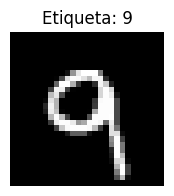

In [4]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"Etiqueta: {tags[y_train[idx][0]]}")
plt.show()

# Construcción del generador

In [5]:
def build_generator(n_class, noise_dim, img_size):
    # label input
    in_label = Input(shape=(1,), name='Label_Input')
    # create an embedding layer for all the 10 classes in the form of a vector of size 50 (ver paper)
    li = Embedding(n_class, 50, name='Embedding')(in_label)
    
    img_size_in = img_size // 4

    n_nodes = img_size_in * img_size_in 
    li = Dense(n_nodes, name='Label_Dense')(li) # Capa densa 
    li = Reshape((img_size_in, img_size_in, 1), name='Label_Reshape')(li) # Cambio la forma de la capa
 
    # image generator input
    in_lat = Input(shape=(noise_dim,), name='Latent_Input') # Capa de entrada de ruido
    n_nodes = 1024 * img_size_in * img_size_in 
    gen = Dense(n_nodes, name='Generator_Dense')(in_lat) # Capa densa
    gen = Reshape((img_size_in, img_size_in, 1024), name='Generator_Reshape')(gen) # Cambio la forma de la capa
    #---------------------------------------------------------------------------------#
    merge = Concatenate(name='Concatenate')([gen, li]) # Concateno las capas
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(1024, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_1')(merge)  # 14x14x1024
    gen = BatchNormalization(name='Generator_BatchNormalization_1')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_1')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_2')(gen)  # 28x28x256
    gen = BatchNormalization(name='Generator_BatchNormalization_2')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_2')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', name='Conv2DTranspose_3')(gen)  # 28x28x128
    gen = BatchNormalization(name='Generator_BatchNormalization_3')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_3')(gen)
    #---------------------------------------------------------------------------------# 
    out_layer = Conv2DTranspose(3, (5, 5), strides=(1,1), activation='tanh', padding='same', name='Output_Conv2DTranspose_4')(gen)  # 28x28x3 
    #---------------------------------------------------------------------------------# 

    generator = Model([in_lat, in_label], out_layer, name='Generator')
    plot_model(generator, to_file='generator_structure.png', show_shapes=True, show_layer_names=True)

    return generator

# Construcción del discriminador

In [6]:
def build_discriminator(n_class, noise_dim, img_size):
    
    # label input
    in_label = Input(shape=(1,), name='Label_Input')
    # This vector of size 50 will be learnt by the discriminator (ver paper)
    li = Embedding(n_class, 50, name='Embedding')(in_label)
    
    n_nodes = img_size * img_size 
    li = Dense(n_nodes, name='Label_Dense')(li)  
    li = Reshape((img_size, img_size, 1), name='Label_Reshape')(li) 
  
    # image input
    in_image = Input(shape=(img_size, img_size, 3), name='Image_Input') 
    in_image = Dropout(0.75, name='Dropout')(in_image)
    merge = Concatenate(name='Concatenate')([in_image, li]) 
 
    # We will combine input label with input image and supply as inputs to the model. 
    #---------------------------------------------------------------------------------#
    fe = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='Conv2D_1')(merge) # 14x14x32
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_1')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='Conv2D_2')(fe) # 7x7x64
    fe = BatchNormalization(name='Generator_BatchNormalization_1')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_2')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='Conv2D_3')(fe) # 7x7x128
    fe = BatchNormalization(name='Generator_BatchNormalization_2')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_3')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(256, (5, 5), strides=(1, 1), padding='same', name='Conv2D_4')(fe) # 7x7x256
    fe = BatchNormalization(name='Generator_BatchNormalization_3')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_4')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(512, (5, 5), strides=(1, 1), padding='same', name='Conv2D_5')(fe) # 7x7x512
    #---------------------------------------------------------------------------------#
    fe = Flatten(name='Flatten')(fe) 
    out_layer = Dense(1, activation='sigmoid', name='Output')(fe)
    #---------------------------------------------------------------------------------#

    discriminator = Model([in_image, in_label], out_layer, name='Discriminator')
    plot_model(discriminator, to_file='discriminator_structure.png', show_shapes=True, show_layer_names=True)

    return discriminator

# Función para visualizar el entrenamiento del generador

In [7]:
def show_samples(num_samples, noise_dim, g_model, epoch):            
  
  fig, axes = plt.subplots(10,num_samples, figsize=(10,20)) 
  fig.tight_layout()
  fig.subplots_adjust(wspace=None, hspace=None)

  for l in np.arange(10):
    random_noise = tf.random.normal(shape=(num_samples, noise_dim))
    label = tf.ones(num_samples)*l
    gen_imgs = g_model.predict([random_noise, label])
    for j in range(gen_imgs.shape[0]):
      img = image.array_to_img(gen_imgs[j], scale=True)
      axes[l,j].imshow(img)
      axes[l,j].yaxis.set_ticks([])
      axes[l,j].xaxis.set_ticks([])

      if j ==0:
        axes[l,j].set_ylabel(tags[l])

  os.makedirs("evolution", exist_ok=True)
  plt.savefig(f"evolution/digits_epoch={epoch}.png", bbox_inches='tight')
  plt.close(fig)

# Definición de las funciones de pérdida (loss)

In [8]:
# Define Loss function for Classification between Real and Fake
bce_loss = tf.keras.losses.BinaryCrossentropy()
 
# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real) # Calculo la loss para las imagenes reales
    fake_loss = bce_loss(tf.zeros_like(fake), fake) # Calculo la loss para las imagenes falsas
    total_loss = real_loss + fake_loss
    return total_loss
   
# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # Calculo la loss para el generador

# Definición de las métricas para evaluar el modelo

In [9]:
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)
    
    return precision, recall, f1, accuracy

# Entrenamiento de la CGAN

- Parámetros de entrenamiento

In [10]:
epoch_count = 100 # Cantidad de epocas 
batch_size = 16 #tamaño del batch hay 60000/16 = 3750 batches
noise_dim = 100 # Dimension del ruido
lr = 0.0002 
n_class = len(tags)  # numero de clases

- Construyo el generador

In [11]:
g_optimizer = RMSprop(learning_rate=lr)
g_model = build_generator(noise_dim=noise_dim, n_class=n_class, img_size=img_size) # Construyo el generador
g_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Latent_Input (InputLayer)   [(None, 100)]                0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                500       ['Label_Input[0][0]']         
                                                                                                  
 Generator_Dense (Dense)     (None, 50176)                5067776   ['Latent_Input[0][0]']        
                                                                                          

- Construyo el discriminador

In [12]:
d_optimizer = RMSprop(learning_rate=lr)
d_model = build_discriminator(n_class=n_class, noise_dim=noise_dim, img_size=img_size) # Construyo el discriminador
d_model.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                500       ['Label_Input[0][0]']         
                                                                                                  
 Label_Dense (Dense)         (None, 1, 784)               39984     ['Embedding[1][0]']           
                                                                                                  
 input_1 (InputLayer)        [(None, 28, 28, 3)]          0         []                            
                                                                                      

- Paso de entrenamiento por batches para el conjunto de entrenamiento (se actualizan los pesos)

In [24]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def train_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):
        
        real_images, real_labels = image_batch 
        # Sample random points in the latent space and concatenate the labels.
        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([random_latent_vectors, real_labels]) #  Genero imagenes falsas
    
        # Train the discriminator.
        with tf.GradientTape() as tape:
            pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
            pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales
            
            d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
        
        
        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas
        
        # Extender las listas con las etiquetas correspondientes
        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas
                
        
        grads = tape.gradient(d_loss, d_model.trainable_variables) # Calculo los gradientes
        d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables)) # Aplico los gradientes al optimizador del discriminador
    
        #-----------------------------------------------------------------#
        
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        
        # Train the generator
        with tf.GradientTape() as tape: 
            fake_images = g_model([random_latent_vectors, real_labels]) # Genero imagenes falsas
            predictions = d_model([fake_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
            g_loss = generator_loss(predictions) # Calculo la loss del generador
        
        grads = tape.gradient(g_loss, g_model.trainable_variables) # Calculo los gradientes
        g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables)) # Aplico los gradientes al optimizador del generador

    return d_loss, g_loss, all_real_labels, all_pred_labels

- Paso de entrenamiento por batches para el conjunto de entrenamiento (no se actualizan los pesos)

In [25]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def test_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch 
        # Sample random points in the latent space and concatenate the labels.
        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([random_latent_vectors, real_labels]) #  Genero imagenes falsas

        pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales
            
        d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
        
        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas
        
        # Extender las listas con las etiquetas correspondientes
        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

        #-----------------------------------------------------------------#
        
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        
        fake_images = g_model([random_latent_vectors, real_labels]) # Genero imagenes falsas
        predictions = d_model([fake_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        g_loss = generator_loss(predictions) # Calculo la loss del generador

    return d_loss, g_loss, all_real_labels, all_pred_labels

In [26]:
def train(train_dataset, test_dataset, epoch_count, batch_size):

    d_loss_list_epoch_train = []
    g_loss_list_epoch_train = []
    d_loss_list_epoch_test = []
    g_loss_list_epoch_test = []
    precision_list_epoch_train = []
    recall_list_epoch_train = []
    f1_list_epoch_train = []
    accuracy_list_epoch_train = []
    precision_list_epoch_test = []
    recall_list_epoch_test = []
    f1_list_epoch_test = []
    accuracy_list_epoch_test = []

 
    for epoch in range(epoch_count):
        print('Epoch: ', epoch+1)
        d_loss_list_batch_train = []
        g_loss_list_batch_train = []
        d_loss_list_batch_test = []
        g_loss_list_batch_test = []
        precision_list_batch_train = []
        recall_list_batch_train = []
        f1_list_batch_train = []
        accuracy_list_batch_train = []
        precision_list_batch_test = []
        recall_list_batch_test = []
        f1_list_batch_test = []
        accuracy_list_batch_test = []

        start = time.time()

        itern = 0
        for image_batch in tqdm(train_dataset, desc=f"Train - batch/batches: "): # Itero sobre todos los batches
            
            d_loss_train, g_loss_train, all_real_labels_train, all_pred_labels_train = train_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_train.append(d_loss_train) # Guardo la loss del discriminador
            g_loss_list_batch_train.append(g_loss_train) # Guardo la loss del generador
            all_real_labels_train = np.array(all_real_labels_train)
            all_pred_labels_train = np.array(all_pred_labels_train)
            all_pred_labels_train = np.array([i[0] for i in all_pred_labels_train]).reshape((-1,))
            
            #print("all_pred_labels: ", all_pred_labels)
            #print("all_real_labels: ", all_real_labels)
            # print("Tipo de all_real_labels:", type(all_real_labels))
            # print("Tipo de all_pred_labels_flat:", type(all_pred_labels))
            # print("Tipo de all_real_labels:", all_real_labels.shape)
            # print("Tipo de all_pred_labels_flat:", all_pred_labels.shape)
            #print("Tipo de all_pred_labels_flat:", type(all_pred_labels))

            precision_train, recall_train, f1_train, accuracy_train = calculate_metrics(np.round(all_real_labels_train), np.round(all_pred_labels_train))
            precision_list_batch_train.append(precision_train)
            recall_list_batch_train.append(recall_train)
            f1_list_batch_train.append(f1_train)
            accuracy_list_batch_train.append(accuracy_train)

            itern=itern+1 

        itern = 0
        for image_batch in tqdm(test_dataset, desc=f"Test - batch/batches: "): # Itero sobre todos los batches
            
            d_loss_test, g_loss_test, all_real_labels_test, all_pred_labels_test = test_step(image_batch, batch_size, noise_dim) # Entreno el modelo
            all_real_labels_test = np.array(all_real_labels_test)
            all_pred_labels_test = np.array(all_pred_labels_test)
            all_pred_labels_test = np.array([i[0] for i in all_pred_labels_test]).reshape((-1,))
            #print("all_pred_labels_test: ", all_pred_labels_test)
            #print("all_real_labels_test: ", all_real_labels_test)
            # print("Tipo de all_real_labels:", type(all_real_labels))
            # print("Tipo de all_pred_labels_flat:", type(all_pred_labels))
            # print("Tipo de all_real_labels:", all_real_labels.shape)
            # print("Tipo de all_pred_labels_flat:", all_pred_labels.shape)
            #print("Tipo de all_pred_labels_flat:", type(all_pred_labels_test))

            d_loss_list_batch_test.append(d_loss_test) # Guardo la loss del discriminador
            g_loss_list_batch_test.append(g_loss_test) # Guardo la loss del generador

            precision_test, recall_test, f1_test, accuracy_test = calculate_metrics(np.round(all_real_labels_test), np.round(all_pred_labels_test))
            precision_list_batch_test.append(precision_test)
            recall_list_batch_test.append(recall_test)
            f1_list_batch_test.append(f1_test)
            accuracy_list_batch_test.append(accuracy_test)

            itern=itern+1 
        
        d_loss_list_epoch_train.append(np.mean(d_loss_list_batch_train))
        g_loss_list_epoch_train.append(np.mean(g_loss_list_batch_train))
        d_loss_list_epoch_test.append(np.mean(d_loss_list_batch_test))
        g_loss_list_epoch_test.append(np.mean(g_loss_list_batch_test))
        precision_list_epoch_train.append(np.mean(precision_list_batch_train))
        recall_list_epoch_train.append(np.mean(recall_list_batch_train))
        f1_list_epoch_train.append(np.mean(f1_list_batch_train))
        accuracy_list_epoch_train.append(np.mean(accuracy_list_batch_train))
        precision_list_epoch_test.append(np.mean(precision_list_batch_test))
        recall_list_epoch_test.append(np.mean(recall_list_batch_test))
        f1_list_epoch_test.append(np.mean(f1_list_batch_test))
        accuracy_list_epoch_test.append(np.mean(accuracy_list_batch_test))

        print (f'Train - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_train)}, Discriminator Loss: {np.mean(d_loss_list_batch_train)}')
        print (f'Test - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_test)}, Discriminator Loss: {np.mean(d_loss_list_batch_test)}\n')
        print (f'Tomó {time.time()-start} segundos. \n\n')

        if epoch % 5 == 0:
            show_samples(4, noise_dim, g_model, epoch)

    return d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_epoch_train, recall_list_epoch_train, f1_list_epoch_train, accuracy_list_epoch_train, precision_list_epoch_test, recall_list_epoch_test, f1_list_epoch_test, accuracy_list_epoch_test

- Entrenamiento del modelo

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # Se crea un dataset con los datos de entrenamiento
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) # Se crea un dataset con los datos de test
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

d_loss_train, g_loss_train, d_loss_test, g_loss_test, precision_train, recall_train, f1_train, accuracy_train, precision_test, recall_test, f1_test, accuracy_test  = train(train_dataset, test_dataset, epoch_count, batch_size)

g_model.save("gmodel_mnist_v1.keras")
d_model.save("dmodel_mnist_v1.keras")

# Graficas de la pérdida para el generador y el discriminador en función de las épocas

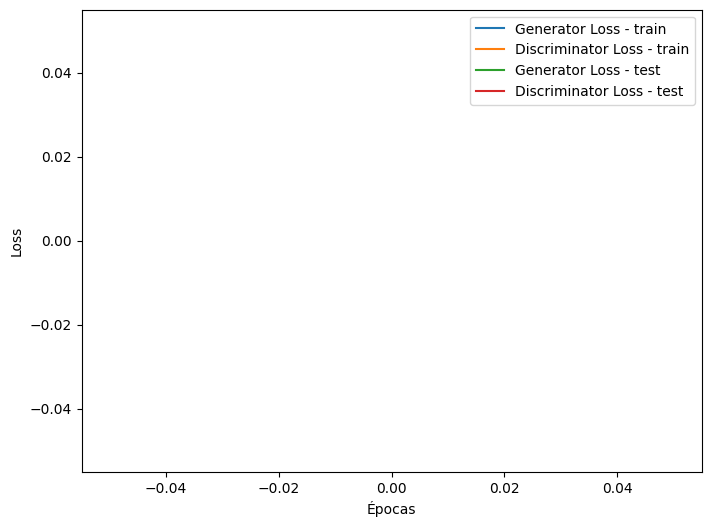

In [28]:
plt.figure(figsize=(8,6))
epochs = np.arange(1, epoch_count+1)
plt.plot(epochs, g_loss_train, label='Generator Loss - train')
plt.plot(epochs, d_loss_train, label='Discriminator Loss - train')
plt.plot(epochs, g_loss_test, label='Generator Loss - test')
plt.plot(epochs, d_loss_test, label='Discriminator Loss - test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

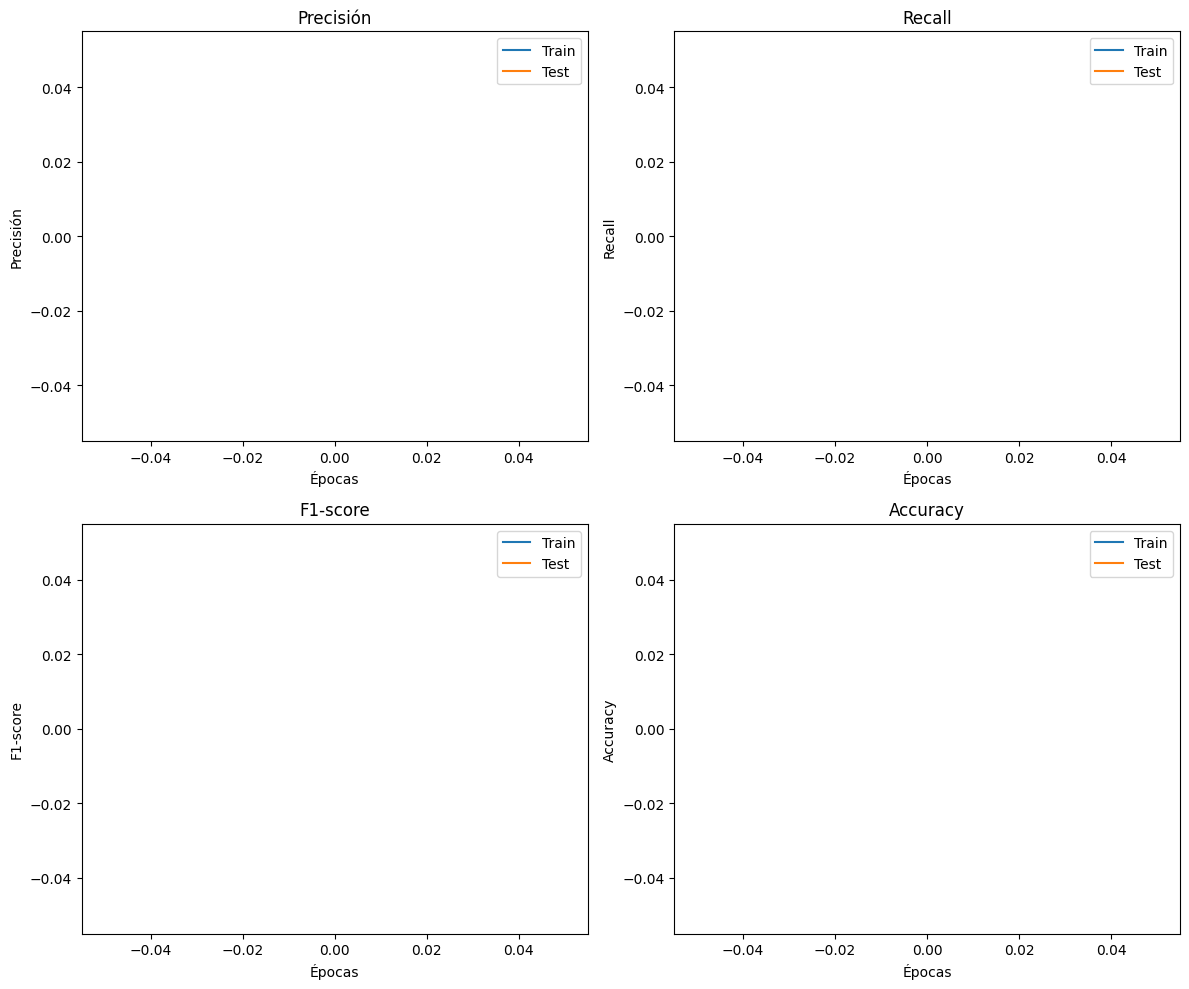

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
epochs = np.arange(1, epoch_count + 1)
# Subplot para Precisión
axs[0, 0].plot(epochs, precision_train, label='Train')
axs[0, 0].plot(epochs, precision_test, label='Test')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Precisión')
axs[0, 0].legend()
axs[0, 0].set_title('Precisión')

# Subplot para Recall
axs[0, 1].plot(epochs, recall_train, label='Train')
axs[0, 1].plot(epochs, recall_test, label='Test')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].legend()
axs[0, 1].set_title('Recall')

# Subplot para F1-score
axs[1, 0].plot(epochs, f1_train, label='Train')
axs[1, 0].plot(epochs, f1_test, label='Test')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('F1-score')
axs[1, 0].legend()
axs[1, 0].set_title('F1-score')

# Subplot para Accuracy
axs[1, 1].plot(epochs, accuracy_train, label='Train')
axs[1, 1].plot(epochs, accuracy_test, label='Test')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].set_title('Accuracy')

plt.tight_layout()
plt.show()

# Generación de un dígito pedido por el usuario

Tamaño imagen generada:  (1, 28, 28, 3)


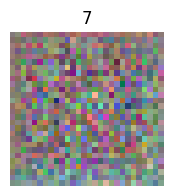

In [30]:
# Cargar el modelo generador
g_model = load_model('gmodel_mnist_v1.keras')

# Preparar la etiqueta para el número 7
numero_a_generar = 7

#label = tf.expand_dims(numero_a_generar, axis=-1) #expando la dimension de y_train para que quede analogo al ejemplo del cifar10
label = tf.ones(1)*numero_a_generar

# Generar ruido aleatorio
noise = tf.random.normal(shape=(1, noise_dim))

# Generar imagen falsa 
generated_image = g_model([noise, label]) #  Genero imagenes falsas
#generated_image = g_model.predict([noise, label])
print("Tamaño imagen generada: ", generated_image.shape)

plt.figure(figsize=(2,2))
img = image.array_to_img(generated_image[0], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"{numero_a_generar}")
plt.show()